# Assignment 3

### Zhe Jing Chin 22221970 1CSD1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

from sklego.preprocessing import RepeatingBasisFunction

import seaborn as sns
import matplotlib.pyplot as plt

#univariate time-series forecasting as there is only 1 observation per time step

# Data Processing

In [2]:
train = pd.read_csv('Electricity-Consumption/train.csv')
test = pd.read_csv('Electricity-Consumption/test.csv')

target = 'electricity_consumption'

In [3]:
train.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [4]:
test.isnull().sum()

ID             0
datetime       0
temperature    0
var1           0
pressure       0
windspeed      0
var2           0
dtype: int64

In [5]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


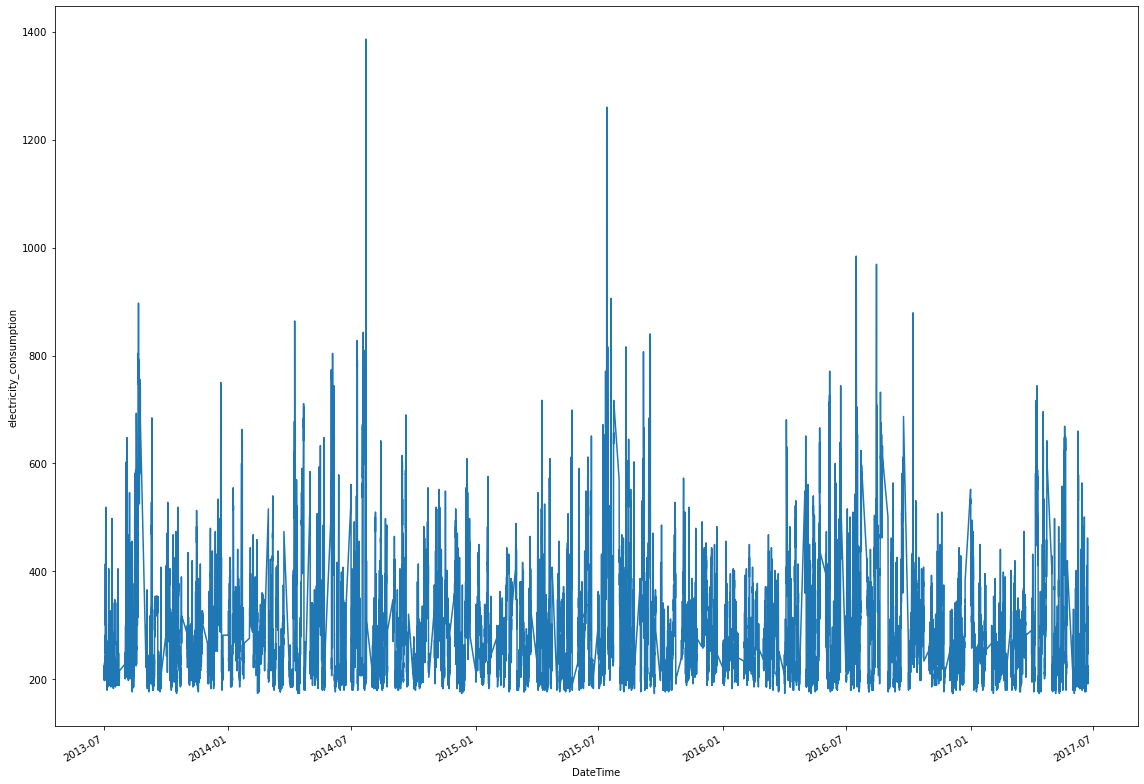

In [6]:
trend_train = train[['datetime', target]].copy()
trend_train['datetime']= pd.to_datetime(trend_train['datetime'])
trend_train = trend_train.set_index(['datetime'])

fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(trend_train[target])
ax.set_xlabel('DateTime')
ax.set_ylabel(target)
fig.autofmt_xdate()
plt.tight_layout()

Text(0.5, 1.0, 'boxcox distribution: 0.11888773500580345')

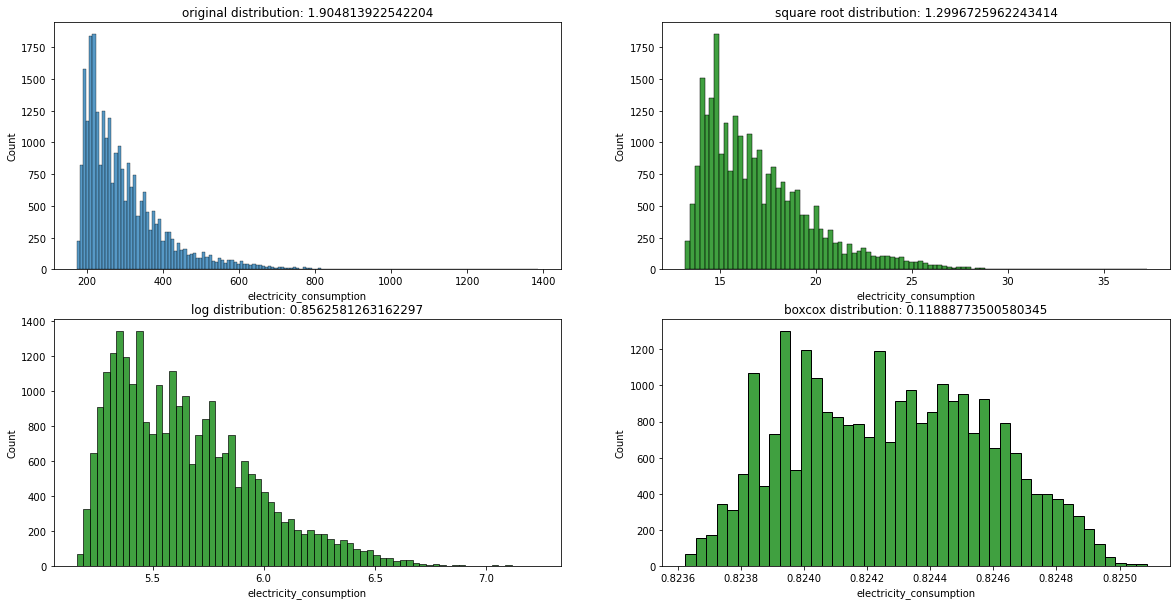

In [7]:
from scipy.stats import boxcox

boxcox_lambda = boxcox(train[target])[1]

from scipy.special import boxcox, inv_boxcox

fig,([ax1,ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(20, 10))

sns.histplot(train[target], ax=ax1); #right skewed data
sns.histplot(np.sqrt(train[target]), color='g',ax=ax2);
sns.histplot(np.log(train[target]), color='g',ax=ax3);
sns.histplot(boxcox(train[target], boxcox_lambda), color='g',ax=ax4);
ax1.set_title(f'original distribution: {train[target].skew()}')
ax2.set_title(f'square root distribution: {np.sqrt(train[target]).skew()}')
ax3.set_title(f'log distribution: {np.log(train[target]).skew()}')
ax4.set_title(f'boxcox distribution: {pd.Series(boxcox(train[target], boxcox_lambda)).skew()}')


From the plots, we can see that boxcox able to transform the target value to a fairly normal distribution, helping the model to learn

In [8]:
train[target] = boxcox(train[target], boxcox_lambda)

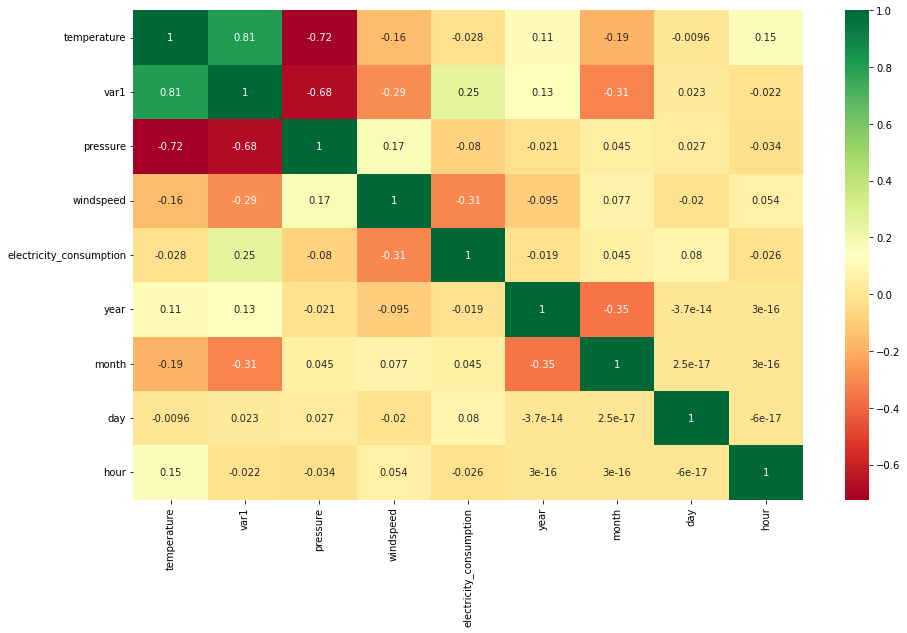

In [9]:
plt.figure(figsize=(15,9))

heatmap_train = train.copy()
heatmap_train.drop(['ID'], axis=1, inplace=True)
heatmap_train['datetime']= pd.to_datetime(heatmap_train['datetime'])
heatmap_train["year"] = heatmap_train["datetime"].dt.year
heatmap_train["month"] = heatmap_train["datetime"].dt.month
heatmap_train["day"] = heatmap_train["datetime"].dt.day
heatmap_train["hour"] = heatmap_train["datetime"].dt.hour

g = sns.heatmap(heatmap_train.corr(),annot=True,cmap="RdYlGn")


## Feature Engineering

Split and aggregate datetime to 6 columns: hour, hour_of_year, hour_of_month, day, day_of_year, month

Apply cyclical encoding method as the circularity features of datetime should be preserved in the data.

In [10]:
#cylical tranform
def hour_transform(df):
    #transform hour of day
    rbf_hour_of_day = RepeatingBasisFunction(n_periods=5,
                             column="hour",
                             input_range=(1,24),
                             remainder="drop")
    rbf_hour_of_day.fit(df)
    data_rbf_day = pd.DataFrame(index=df.index, columns=[f"rbf_hday_{i}" for i in range(1,6)], data=rbf_hour_of_day.transform(df))

    #transform hour of month
    rbf_hour_of_month = RepeatingBasisFunction(n_periods=5,
                             column="hour_of_month",
                             input_range=(1,744),
                             remainder="drop")
    rbf_hour_of_month.fit(df)
    data_rbf_month = pd.DataFrame(index=df.index, columns=[f"rbf_hmonth_{i}" for i in range(1,6)], data=rbf_hour_of_month.transform(df))
    
    #transform hour of year
    rbf_hour_of_year = RepeatingBasisFunction(n_periods=5,
                             column="hour_of_year",
                             input_range=(1,8760),
                             remainder="drop")
    rbf_hour_of_year.fit(df)
    data_rbf_year = pd.DataFrame(index=df.index, columns=[f"rbf_hyear_{i}" for i in range(1,6)], data=rbf_hour_of_year.transform(df))
    
    return data_rbf_day, data_rbf_month, data_rbf_year

def day_transform(df):
    #transform day of month
    rbf_day_of_month = RepeatingBasisFunction(n_periods=5,
                             column="day",
                             input_range=(1,31),
                             remainder="drop")
    rbf_day_of_month.fit(df)
    data_rbf_month = pd.DataFrame(index=df.index, columns=[f"rbf_dmonth_{i}" for i in range(1,6)], data=rbf_day_of_month.transform(df))
    
    #transform day of year
    rbf_day_of_year = RepeatingBasisFunction(n_periods=5,
                             column="day_of_year",
                             input_range=(1,365),
                             remainder="drop")
    rbf_day_of_year.fit(df)
    data_rbf_year = pd.DataFrame(index=df.index, columns=[f"rbf_dyear_{i}" for i in range(1,6)], data=rbf_day_of_year.transform(df))
    
    return data_rbf_month, data_rbf_year

def month_transform(df):
    #transform month of year
    rbf_month_of_year = RepeatingBasisFunction(n_periods=5,
                             column="month",
                             input_range=(1,12),
                             remainder="drop")
    rbf_month_of_year.fit(df)
    data_rbf_year = pd.DataFrame(index=df.index, columns=[f"rbf_myear_{i}" for i in range(1,6)], data=rbf_month_of_year.transform(df))
    
    return data_rbf_year

### Process datetime features for train set

In [11]:
#split datetime
import datetime

#convert datetime column to datetime type
def extractDateFeatures(df):
    df['datetime']= pd.to_datetime(df['datetime'])

    df["hour"] = df["datetime"].dt.hour
    df["hour_of_year"] = df["datetime"].dt.dayofyear*24 + (df['hour']+1) - 24
    df["hour_of_month"] = df["datetime"].dt.day*24 + (df['hour']+1) - 24

    df["day"] = df["datetime"].dt.day
    df["day_of_year"] = df["datetime"].dt.dayofyear

    df["month"] = df["datetime"].dt.month


    # #drop unnecessary columns
    cols = ['ID']
    df_dropped = df.drop(cols, axis=1)
    df_dropped = df_dropped.set_index('datetime')
#     df_dropped.index.freq = 'H'

    hour_day, hour_month, hour_year = hour_transform(df_dropped)
    day_month, day_year = day_transform(df_dropped)
    month_year = month_transform(df_dropped)

    df_rbf = df_dropped.drop(['hour', 'hour_of_month', 'hour_of_year', 'day', 'day_of_year', 'month'], axis=1)
    df_rbf = pd.concat([df_rbf, hour_day, hour_month, hour_year, day_month, day_year, month_year], axis=1)
    
    return df_rbf

train_rbf = extractDateFeatures(train)
test_rbf = extractDateFeatures(test)


In [12]:
### Add previous observation to current 

# To use previous observation as a feature to predict for current hour.
# train_rbf['prev-1'] = train_rbf[target].shift(+1)

# # drop first row as "prev-1" would be nan
# train_rbf = train_rbf[1:]

### Add monthly average consumption as feature

In [13]:
monthly_avg = train_rbf.groupby(pd.PeriodIndex(train_rbf.index, freq="M"))[target].mean()
# yearly_avg = train_rbf.groupby(pd.PeriodIndex(train_rbf.index, freq="Y"))[target].mean()

train_m_avg = []
for index, row in train_rbf.iterrows():
#     print(monthly_avg['{}-{:02d}'.format(index.year, index.month)])
    train_m_avg.append(monthly_avg['{}-{:02d}'.format(index.year, index.month)])


test_m_avg = []
for index, row in test_rbf.iterrows():
#     print(monthly_avg['{}-{:02d}'.format(index.year, index.month)])
    test_m_avg.append(monthly_avg['{}-{:02d}'.format(index.year, index.month)])

In [14]:
train_rbf['monthly_avg'] = train_m_avg
# train_rbf['yearly_avg'] = train_y_avg

test_rbf['monthly_avg'] = test_m_avg

### Train and Validation split + Features and Target split

In [15]:
#split train set to train and validation set:

#validation set is taking last 5 days of each month in train set following the pattern in test set to 
#ensure the performance measured is consistent
val_rbf = train_rbf[train_rbf.index.get_level_values('datetime').day >= 23-4]

X_train = train_rbf.drop([target], axis=1)
y_train = train_rbf[target]

X_val = val_rbf.drop([target], axis=1)
y_val = val_rbf[target]


### Declare numerical and categorical columns to encode

In [16]:
ncol = X_train.select_dtypes(include=['int64', 'float64']).columns
ccol = X_train.select_dtypes(include=['object']).columns

#we use OneHotEncoder for this case as the var2 has no ordering
transformer = [('categorical', OneHotEncoder(), ccol), ('numerical', MinMaxScaler(), ncol)]
encoding = ColumnTransformer(transformers=transformer)

# from sklearn.preprocessing import PolynomialFeatures

# polynomial_features = PolynomialFeatures()

# scaler = StandardScaler()

# X_train_ncol = polynomial_features.fit_transform(X_train[ncol])
# X_train_ccol = scaler.fit_transform(data)



# X_train[ccol]

# # X_train_encoded = encoding.fit_transform(X_train)
# # X_train_pf = polynomial_features.fit_transform(X_train_encoded)

# # X_val_encoded = encoding.transform(X_val)
# # X_val_pf = polynomial_features.transform(X_val_encoded)

# # X_test_encoded = encoding.transform(test_rbf)
# # X_test_pf = polynomial_features.transform(X_test_encoded)

# Model 1 - Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit()
model1 = LinearRegression()

pipeline1 = Pipeline(steps=[('encode',encoding), ('model', model1)])
cv1 = cross_val_score(pipeline1, X_train, y_train, cv=tscv, scoring='r2') #neg_mean_squared_error
pipeline1.fit(X_train, y_train)
model1_r2_train = pipeline1.score(X_train, y_train)
model1_r2_val = pipeline1.score(X_val, y_val) #r2 
print("====         Model 1 - Linear Regression       ====\n")
print("----    Cross Validate R2   ----: ", cv1.mean())
print("----         Train R2       ----: ", model1_r2_train)
print("----      Validation R2     ----: ", model1_r2_val)


# pipeline1_2 = Pipeline(steps=[('encode',encoding), ("polynomial_features", polynomial_features), ('model', model1)])
# # cv1_2 = cross_val_score(pipeline1_2, X_train, y_train, cv=tscv, scoring='r2') #neg_mean_squared_error
# pipeline1_2.fit(X_train, y_train)
# model1_2_r2_train = pipeline1_2.score(X_train, y_train)
# model1_2_r2_val = pipeline1_2.score(X_val, y_val) #r2 
# print("\n\n----    With Polynomial Features   ---- ")
# # print("----    Cross Validate R2   ----: ", cv1_2.mean())
# print("----         Train R2       ----: ", model1_2_r2_train)
# print("----      Validation R2     ----: ", model1_2_r2_val)

# de-boxcox predicted values
test_unseen_model1 = inv_boxcox(pipeline1.predict(test_rbf), boxcox_lambda)

====         Model 1 - Linear Regression       ====

----    Cross Validate R2   ----:  0.31977937202487844
----         Train R2       ----:  0.4792896196692157
----      Validation R2     ----:  0.5389713756849599


In [31]:
def predict_unseen(df, pipeline):
    sub = {"ID": [f"{i}" for i in range(len(df))],
           "datetime": [f"{str(index)}" for index, row in df.iterrows()],
           "Predict": inv_boxcox(pipeline.predict(df), boxcox_lambda)}
    sub_df = pd.DataFrame(sub)
    sub_df.to_csv(f"22221970_{type(pipeline['model']).__name__}.csv", sep=",", header=1, index=None)

In [32]:
predict_unseen(test_rbf, pipeline1)

In [18]:
Pipeline(steps=[('encode',encoding), ('model', model1)])

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  Index(['var2'], dtype='object')),
                                                 ('numerical', MinMaxScaler(),
                                                  Index(['temperature', 'var1', 'pressure', 'windspeed', 'rbf_hday_1',
       'rbf_hday_2', 'rbf_hday_3', 'rbf_hday_4', 'rbf_hday_5', 'rbf_hmonth_1',
       'rbf_hmonth_2', 'rbf_hmonth_3', 'rbf_hmonth_4', 'rbf_hmonth_5',
       'rbf_hyear_1', 'rbf_hyear_2', 'rbf_hyear_3', 'rbf_hyear_4',
       'rbf_hyear_5', 'rbf_dmonth_1', 'rbf_dmonth_2', 'rbf_dmonth_3',
       'rbf_dmonth_4', 'rbf_dmonth_5', 'rbf_dyear_1', 'rbf_dyear_2',
       'rbf_dyear_3', 'rbf_dyear_4', 'rbf_dyear_5', 'rbf_myear_1',
       'rbf_myear_2', 'rbf_myear_3', 'rbf_myear_4', 'rbf_myear_5',
       'monthly_avg'],
      dtype='object'))])),
                ('model', LinearRegression())])

# Model 2 - ElasticNet

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit()

model2 = ElasticNet()

search = GridSearchCV(estimator=model2,
                    param_grid={'alpha':np.logspace(-5,2,8),
                                'l1_ratio':[0,.2,.4,.6,.8,1]},
                    scoring='r2',
                    n_jobs=1,
                    cv=tscv
                     )

transformer = [('categorical', OneHotEncoder(), ccol), ('numerical', StandardScaler(), ncol)]
encoding = ColumnTransformer(transformers=transformer)

pipeline2 = Pipeline(steps=[('encode',encoding), ('model', search)])


pipeline2.fit(X_train, y_train)
print(search.best_params_)
#{'alpha': 0.0001, 'l1_ratio': 0.4}
print(search.best_score_)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e-04, tolerance: 3.838e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e-04, tolerance: 8.692e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e-04, tolerance: 3.838e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e-04, tolerance: 8.692e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-04, tolerance: 3.838e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.174e-04, tolerance: 8.692e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using o

{'alpha': 1e-05, 'l1_ratio': 0.2}
0.45290772515995104


In [20]:
model2 = ElasticNet(**{'alpha': 1e-05, 'l1_ratio': 0.2})

transformer = [('categorical', OneHotEncoder(), ccol), ('numerical', StandardScaler(), ncol)]
encoding = ColumnTransformer(transformers=transformer)

pipeline2 = Pipeline(steps=[('encode',encoding), ('model', model2)])

cv2 = cross_val_score(pipeline2, X_train, y_train, cv=tscv, scoring='r2')

pipeline2.fit(X_train, y_train)
model2_r2_train = pipeline2.score(X_train, y_train)
model2_r2_val = pipeline2.score(X_val, y_val)

print("====           Model 2 - ElasticNet         ====\n")
print("----    Cross Validate R2   ----: ", cv2.mean())
print("----         Train R2       ----: ", model2_r2_train)
print("----      Validation R2     ----: ", model2_r2_val)

====           Model 2 - ElasticNet         ====

----    Cross Validate R2   ----:  0.45313268233589576
----         Train R2       ----:  0.47240690725692136
----      Validation R2     ----:  0.522808271636243


In [33]:
predict_unseen(test_rbf, pipeline2)

In [21]:
Pipeline(steps=[('encode',encoding), ('model', model2)])

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  Index(['var2'], dtype='object')),
                                                 ('numerical', StandardScaler(),
                                                  Index(['temperature', 'var1', 'pressure', 'windspeed', 'rbf_hday_1',
       'rbf_hday_2', 'rbf_hday_3', 'rbf_hday_4', 'rbf_hday_5', 'rbf_hmonth_1',
       'rbf_hmonth_2', 'rbf_hmonth_3', 'rbf_hmonth_4', 'rbf_hmonth_5',
       'rbf_hye..._hyear_2', 'rbf_hyear_3', 'rbf_hyear_4',
       'rbf_hyear_5', 'rbf_dmonth_1', 'rbf_dmonth_2', 'rbf_dmonth_3',
       'rbf_dmonth_4', 'rbf_dmonth_5', 'rbf_dyear_1', 'rbf_dyear_2',
       'rbf_dyear_3', 'rbf_dyear_4', 'rbf_dyear_5', 'rbf_myear_1',
       'rbf_myear_2', 'rbf_myear_3', 'rbf_myear_4', 'rbf_myear_5',
       'monthly_avg'],
      dtype='object'))])),
                ('model', ElasticNet(alpha=1e-05, l1_ratio=0.2))])

# Additional Model - CatBoostRegressor

## Better performance in computational time and R2

In [22]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

model2 = CatBoostRegressor(verbose=0)

parameters = {
              'depth'         : range(7, 10, 1),
              'learning_rate' : np.arange(1, 1.01, 0.1),
              'iterations'    : range(200, 401, 100)
            }
grid_search = GridSearchCV(estimator = model2, 
                        param_grid = parameters, 
                        n_jobs=4)

pipeline2_1 = Pipeline(steps=[('encode',encoding), ('model', grid_search)])

pipeline2_1.fit(X_train, y_train)
print(" Results from Grid Search " )
# print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)


 Results from Grid Search 

 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 200, 'learning_rate': 1.0}


In [23]:
parameters = {'depth': 7, 'iterations': 200, 'learning_rate': 1.0}

model2 = CatBoostRegressor(verbose=0, **parameters)

pipeline2_2 = Pipeline(steps=[('encode',encoding), ('model', model2)])

# cv2 = cross_val_score(pipeline2_1, X_train, y_train, cv=tscv, scoring='r2')

pipeline2_2.fit(X_train, y_train)
model2_2_r2_train = pipeline2_2.score(X_train, y_train)
model2_2_r2_val = pipeline2_2.score(X_val, y_val)

# print("\n\n----    With Polynomial Features   ---- ")
# print("----    Cross Validate R2   ----: ", cv1_2.mean())
print("----         Train R2       ----: ", model2_2_r2_train)
print("----      Validation R2     ----: ", model2_2_r2_val)

----         Train R2       ----:  0.8995176180305692
----      Validation R2     ----:  0.9125620616141018


In [24]:
r2_score(pipeline2_2.predict(X_train), y_train)

0.8869443635840306

In [25]:
Pipeline(steps=[('encode',encoding), ('model', grid_search)])

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  Index(['var2'], dtype='object')),
                                                 ('numerical', StandardScaler(),
                                                  Index(['temperature', 'var1', 'pressure', 'windspeed', 'rbf_hday_1',
       'rbf_hday_2', 'rbf_hday_3', 'rbf_hday_4', 'rbf_hday_5', 'rbf_hmonth_1',
       'rbf_hmonth_2', 'rbf_hmonth_3', 'rbf_hmonth_4', 'rbf_hmonth_5',
       'rbf_hye...
       'rbf_dmonth_4', 'rbf_dmonth_5', 'rbf_dyear_1', 'rbf_dyear_2',
       'rbf_dyear_3', 'rbf_dyear_4', 'rbf_dyear_5', 'rbf_myear_1',
       'rbf_myear_2', 'rbf_myear_3', 'rbf_myear_4', 'rbf_myear_5',
       'monthly_avg'],
      dtype='object'))])),
                ('model',
                 GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x15b6a0520>,
                              n_jobs=4,
                              param_grid={'depth': range(7, 10),
                                          'iterations': range(200, 401, 100),
                                          'learning_rate': array([1.])}))])